# Airline Passenger Satisfaction

**Author:** Piyush Ramteke

This notebook is a complete pipeline for the **Airline Passenger Satisfaction** Kaggle dataset.

Place `train.csv` (and `test.csv` if available) in the same directory as this notebook before running.

Sections:
1. Setup & Imports
2. Load Data
3. Quick EDA
4. Preprocessing & Feature Engineering
5. Model Building (Random Forest)
6. Evaluation & Feature Importance
7. Save Model


In [11]:
# 1) Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

print('Libraries imported successfully')


Libraries imported successfully


In [12]:
# 2) Load Data
# Make sure 'train.csv' is in the same folder as this notebook.

if not any(os.path.exists(fname) for fname in ['train.csv', 'test.csv']):
    print('WARNING: train.csv and test.csv not found in working directory.\nPlease download the Airline Passenger Satisfaction dataset from Kaggle and place train.csv here.')

# Try loading train.csv
try:
    data = pd.read_csv('train.csv')
    print('Loaded train.csv — shape:', data.shape)
except Exception as e:
    print('Could not load train.csv:', e)
    data = pd.DataFrame()

# Show top rows if loaded
if not data.empty:
    display(data.head())
    display(data.info())


Loaded train.csv — shape: (103904, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

None

## 3) Quick EDA
We'll inspect distribution of the target, missing values, and a few key plots.

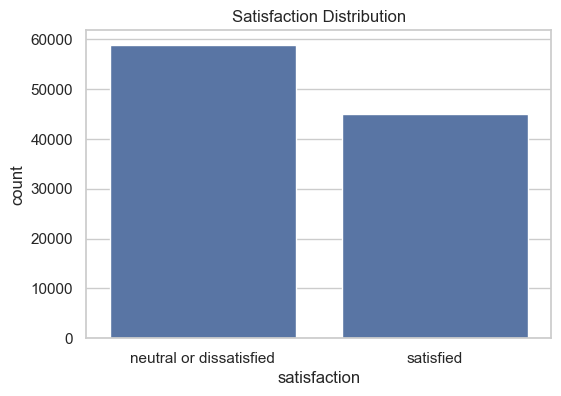

In [13]:
# Quick EDA (run only if data loaded)
if data.empty:
    raise SystemExit('Load the dataset first (train.csv) and re-run this cell.')

# Target distribution
plt.figure(figsize=(6,4))
ax = sns.countplot(x='satisfaction', data=data)
ax.set_title('Satisfaction Distribution')
plt.show()

In [14]:
# Missing values
print('\nMissing values per column:')
print(data.isnull().sum())


Missing values per column:
Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes     

In [15]:
# Numeric summary
display(data.describe())

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


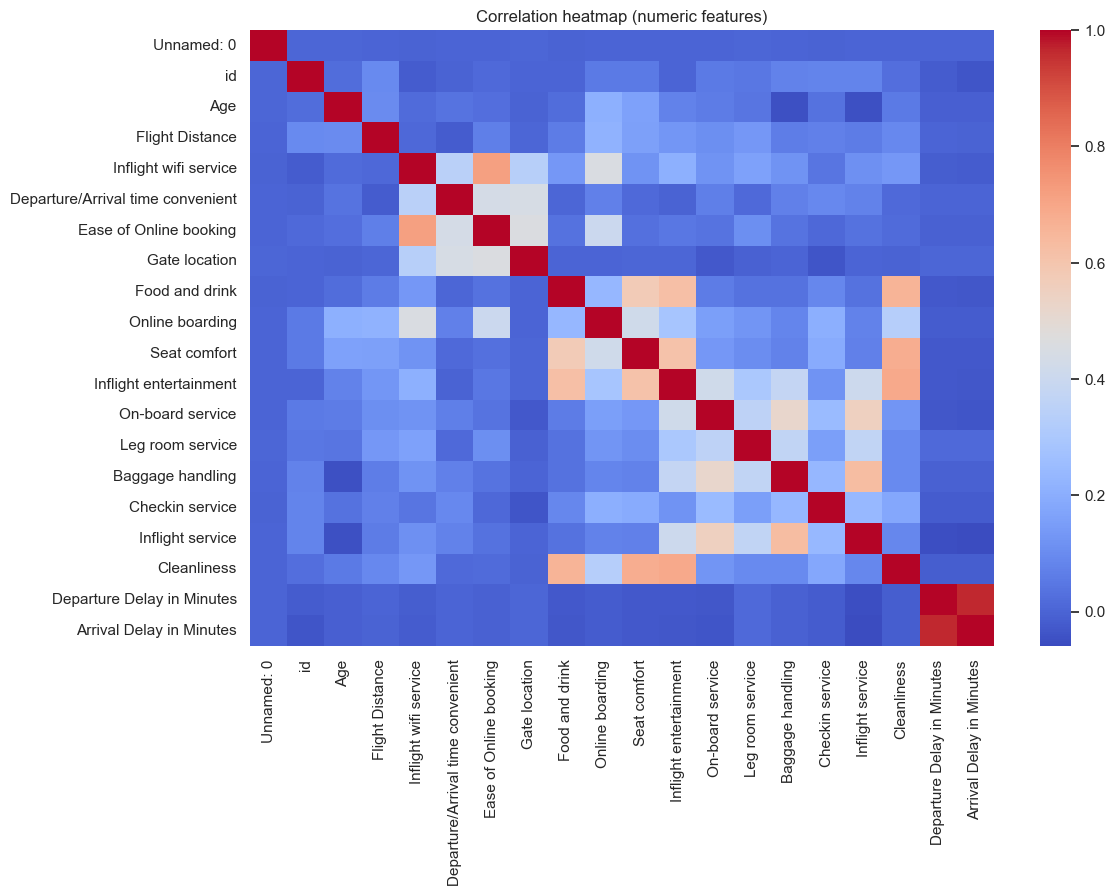

In [16]:
# Correlation heatmap for numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,8))
sns.heatmap(data[numeric_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation heatmap (numeric features)')
plt.show()

## Correlation Heatmap – Key Points
This heatmap shows how strongly each numeric feature is related to another.
Most values are blue, meaning the features are not strongly correlated with each other. This is good because each feature provides independent information to the model.

The only strong correlation is between Departure Delay and Arrival Delay, which is expected (late departure leads to late arrival).
Service-related features (wifi, comfort, cleanliness, entertainment, etc.) show small positive correlations, meaning passengers who rate one service well often rate others well too.

Overall, the heatmap shows no multicollinearity problems, and all features can be safely used in modeling.

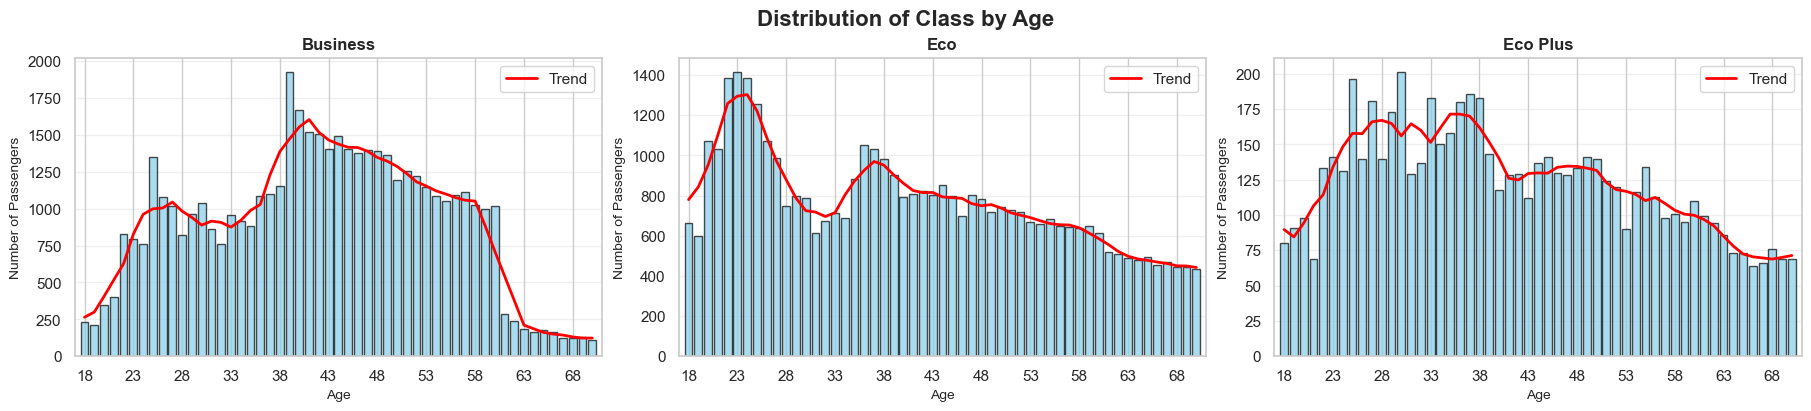

In [17]:
# Visualization: Distribution of Travel Class by Age

# Load data using the existing 'data' variable if available, otherwise load from CSV
if 'data' in locals() and not data.empty:
    df = data.copy()
else:
    df = pd.read_csv('train.csv')

# --- Preprocessing for plotting ---
# Restrict age range to sensible values (adjust if needed)
min_age, max_age = 18, 70
age_range = list(range(min_age, max_age + 1))

# Ensure Age is integer and filter
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df = df.dropna(subset=['Age'])
df['Age'] = df['Age'].astype(int)
df = df[(df['Age'] >= min_age) & (df['Age'] <= max_age)]

# Use 'Class' column for different categories (Eco, Eco Plus, Business)
if 'Class' in df.columns:
    category_col = 'Class'
    travel_classes = df[category_col].dropna().unique().tolist()
elif 'Type of Travel' in df.columns:
    category_col = 'Type of Travel'
    travel_classes = df[category_col].dropna().unique().tolist()
else:
    print("Error: Expected columns not found in dataset")
    travel_classes = []

if travel_classes:
    # --- Figure layout ---
    n = len(travel_classes)
    cols = min(3, n)
    rows = int(np.ceil(n / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), constrained_layout=True)
    
    # Handle single subplot case
    if n == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n > 1 else [axes]
    
    # Plotting
    for i, category in enumerate(travel_classes):
        ax = axes[i]
        sub = df[df[category_col] == category]
        
        # Count per age (every integer age between min_age and max_age)
        counts = sub['Age'].value_counts().reindex(age_range, fill_value=0).sort_index()
        ages = np.array(counts.index)
        vals = counts.values
        
        # Bar chart
        ax.bar(ages, vals, width=0.8, alpha=0.7, color='skyblue', edgecolor='black')
        
        # Smooth trend (rolling mean)
        smooth = pd.Series(vals, index=ages).rolling(window=5, center=True, min_periods=1).mean()
        ax.plot(ages, smooth, color='red', linewidth=2, label='Trend')
        
        # Labels and styling
        ax.set_title(f'{category}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Age', fontsize=10)
        ax.set_ylabel('Number of Passengers', fontsize=10)
        ax.set_xlim(min_age - 1, max_age + 1)
        ax.set_xticks(list(range(min_age, max_age + 1, 5)))
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    # Clear any unused subplots
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle(f'Distribution of {category_col} by Age', fontsize=16, fontweight='bold')
    plt.show()
else:
    print("No data to plot")


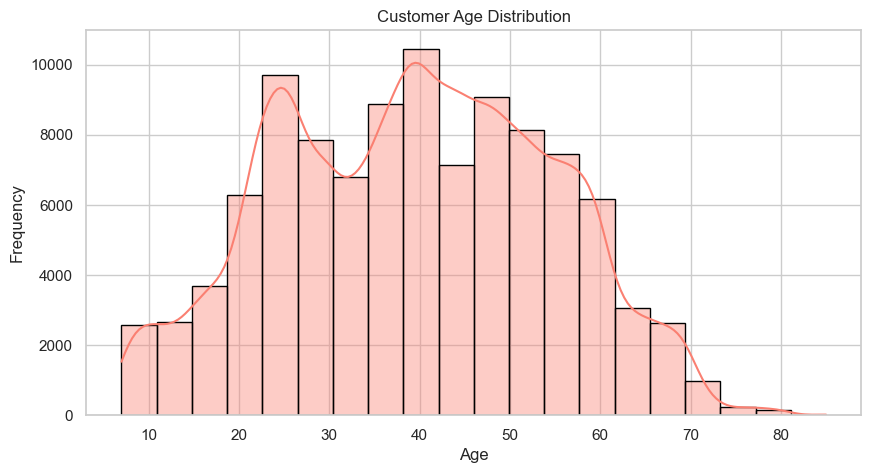

In [18]:
plt.figure(figsize=(10, 5))

# Histogram with KDE
sns.histplot(
    data['Age'], 
    bins=20, 
    kde=True, 
    color='salmon', 
    edgecolor='black',
    alpha=0.4
)

plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


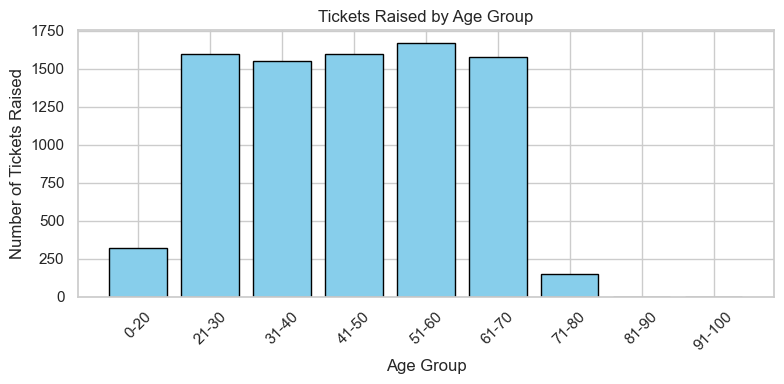

In [19]:
# Age groups on x-axis
age_groups = ['0-20', '21-30', '31-40', '41-50',
              '51-60', '61-70', '71-80', '81-90', '91-100']

# Number of tickets for each age group (example values – change as needed)
tickets = [320, 1600, 1550, 1600, 1670, 1580, 150, 0, 0]

plt.figure(figsize=(8, 4))
plt.bar(age_groups, tickets, color='skyblue', edgecolor='black')

plt.title('Tickets Raised by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Tickets Raised')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 4) Preprocessing & Feature Engineering
Steps:
- Handle missing values
- Encode categorical features
- Scale numeric features (optional)
- Create X and y

In [20]:
# Preprocessing
# 1) Drop rows with NA in target if any
if data['satisfaction'].isnull().any():
    data = data.dropna(subset=['satisfaction'])

In [21]:
# 2) Simple fill for other missing values (if any)
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if data[col].dtype == 'O':
            data[col].fillna(data[col].mode()[0], inplace=True)
        else:
            data[col].fillna(data[col].median(), inplace=True)

In [22]:
# 3) Encode categorical variables
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
print('Categorical columns:', cat_cols)
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    le_dict[col] = le

Categorical columns: ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']


In [23]:
# 4) Prepare features and target
X = data.drop(['satisfaction'], axis=1)
y = data['satisfaction']

print('\nFeature matrix shape:', X.shape)
print('Target shape:', y.shape)


Feature matrix shape: (103904, 24)
Target shape: (103904,)


In [24]:
# 5) Optional: Scale numeric features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Save encoders and scaler for later (in memory) - will save model & pipeline later
import pickle
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(le_dict, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print('Preprocessing complete. Encoders and scaler saved locally.')

Preprocessing complete. Encoders and scaler saved locally.


## 5) Model Building — Random Forest
Train a Random Forest classifier and evaluate performance.



## **Classification Report – Explanation (Short Points)**

* **Accuracy = 96%** → Model correctly predicts 96 out of 100 passengers.
* **Class 0 (Neutral/Dissatisfied):**

  * Precision 0.96 → When model says "0", it is correct 96% of the time.
  * Recall 0.98 → Model captures 98% of all actual class 0 cases.
* **Class 1 (Satisfied):**

  * Precision 0.97 → Model is 97% correct when predicting "1".
  * Recall 0.94 → Captures 94% of all actual class 1 cases.
* **F1-scores (0.97 and 0.96)** show a good balance between precision and recall.
* Balanced performance means the model is **strong for both classes**.

Train set: (77928, 24) Test set: (25976, 24)
Accuracy: 0.9626193409300893

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     14720
           1       0.97      0.94      0.96     11256

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976

Accuracy: 0.9626193409300893

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     14720
           1       0.97      0.94      0.96     11256

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976



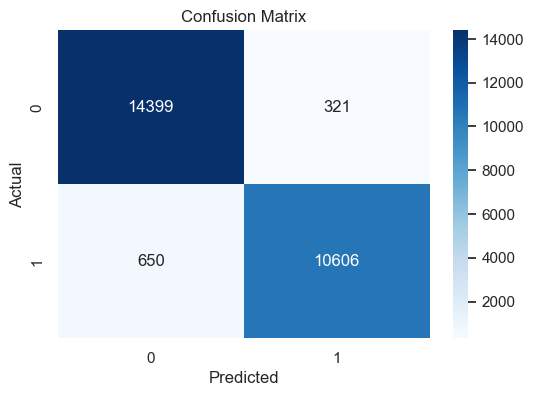

In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print('Train set:', X_train.shape, 'Test set:', X_test.shape)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## **Confusion Matrix – Explanation (Short Points)**

* The matrix shows how many passengers were correctly or incorrectly classified.
* **Top-left (14399)** → Correctly predicted *Neutral/Dissatisfied* (Class 0).
* **Top-right (321)** → Class 0 wrongly predicted as Class 1.
* **Bottom-left (650)** → Class 1 wrongly predicted as Class 0.
* **Bottom-right (10606)** → Correctly predicted *Satisfied* (Class 1).
* Overall, the model makes **very few mistakes**, indicating strong performance.

---

### Feature Importance

In [26]:
# Feature importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feat_imp.head(15))

Online boarding           0.162909
Inflight wifi service     0.141778
Type of Travel            0.094871
Class                     0.093122
Inflight entertainment    0.059340
Leg room service          0.039219
Ease of Online booking    0.038878
Customer Type             0.037711
Seat comfort              0.035748
Flight Distance           0.031820
On-board service          0.029932
Age                       0.028384
id                        0.027529
Cleanliness               0.027321
Baggage handling          0.024732
dtype: float64


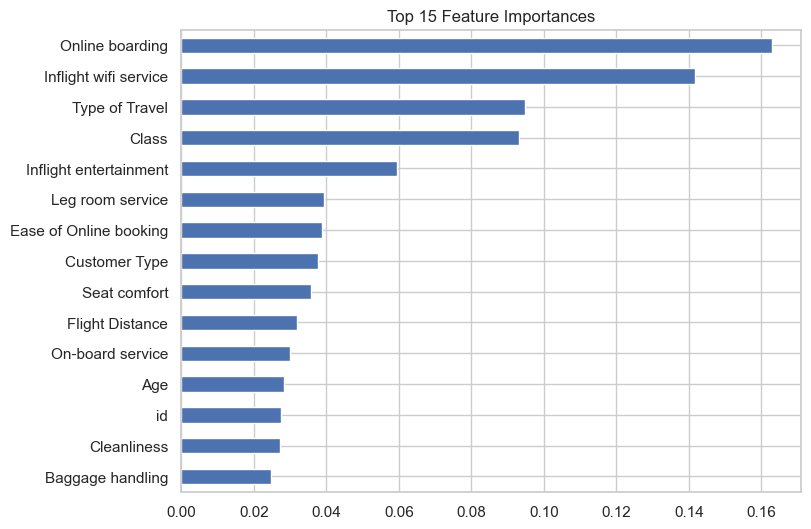

In [27]:
plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances')
plt.show()

## 6) Evaluation & Feature Importance

In [ ]:
# Small GridSearch (optional — may take time depending on machine)
# Uncomment to run
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
best_rf = grid.best_estimator_


## 7) Save Model & Artifacts

In [ ]:
# Save model and artifacts
joblib.dump(rf, 'rf_airline_satisfaction_model.pkl')
print('Saved Random Forest model to rf_airline_satisfaction_model.pkl')

# Artifacts saved: label_encoders.pkl, scaler.pkl, rf_airline_satisfaction_model.pkl
print('Saved artifacts: label_encoders.pkl, scaler.pkl, rf_airline_satisfaction_model.pkl')
